<a href="https://colab.research.google.com/github/Varun-Singhal/Neural-Network/blob/master/TPU_Resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
! pip uninstall tensorflow
! pip install tensorflow-gpu

Uninstalling tensorflow-1.13.1:
  Would remove:
    /usr/local/bin/freeze_graph
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.6/dist-packages/tensorflow-1.13.1.dist-info/*
    /usr/local/lib/python3.6/dist-packages/tensorflow/*
Proceed (y/n)? y
  Successfully uninstalled tensorflow-1.13.1
    100% |████████████████████████████████| 345.2MB 51kB/s 


In [0]:
import tensorflow as tf
from tensorflow.keras.layers import SeparableConv2D, Input,BatchNormalization, MaxPool2D, Conv2D, concatenate
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.activations import relu, softmax
import numpy as np
import matplotlib.pyplot as plt

(60000, 28, 28)


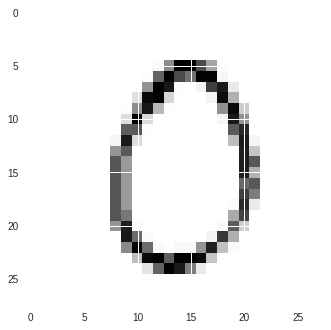

In [46]:
(train_x,train_y),(test_x,test_y) = mnist.load_data()
print(train_x.shape)
plt.imshow(train_x[210,:,:])
train_x = np.expand_dims(train_x, -1)
test_x = np.expand_dims(test_x, -1)


In [0]:
import os
TPU_Worker = "grpc://" + os.environ['COLAB_TPU_ADDR']


In [36]:

inp = Input((28,28,1))
layer1 = SeparableConv2D(32,(3,3), padding='same',activation=relu)(inp)
layer = layer1
layer1 = SeparableConv2D(56,(3,3),padding='same',activation=relu)(layer1)
layer1 = concatenate([layer1,layer])
layer1 = BatchNormalization()(layer1)
layer1 = MaxPool2D(2,2)(layer1)


layer2 = Conv2D(32,(3,3),padding='same',activation=relu)(layer1)
layer2 = concatenate([layer2,layer1])
layer=layer2
layer2 = SeparableConv2D(56,(3,3),padding='same',activation=relu)(layer2)
layer2 = concatenate([layer2,layer])
layer2 = BatchNormalization()(layer2)
layer2 = MaxPool2D(2,2)(layer2)


layer3 = Conv2D(10,(7,7),activation=softmax)(layer2)
model = Model(inputs = inp,outputs = layer3)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
separable_conv2d_28 (SeparableC (None, 28, 28, 32)   73          input_12[0][0]                   
__________________________________________________________________________________________________
separable_conv2d_29 (SeparableC (None, 28, 28, 56)   2136        separable_conv2d_28[0][0]        
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 28, 28, 88)   0           separable_conv2d_29[0][0]        
                                                                 separable_conv2d_28[0][0]        
__________

In [37]:
tpu_model = tf.contrib.tpu.keras_to_tpu_model(
    model,
    strategy=tf.contrib.tpu.TPUDistributionStrategy(
        tf.contrib.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])))
    

INFO:tensorflow:Querying Tensorflow master (grpc://10.126.177.170:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 12737954895211319733)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 7836888578177070110)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 12747034347305680376)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 11372976950024809314)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 9824878565812260724)
INFO:tensorflow:*** Available Device: _DeviceAttribut

In [0]:

tpu_model.compile(
    optimizer=tf.train.AdamOptimizer(learning_rate=1e-3, ),
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=['sparse_categorical_accuracy']
)

In [39]:
tpu_model.fit(train_x,train_y,epochs=5)

Epoch 1/5
INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(4,), dtype=tf.int32, name='core_id_30'), TensorSpec(shape=(4, 28, 28, 1), dtype=tf.float32, name='input_12_10'), TensorSpec(shape=(4, 1), dtype=tf.int32, name='conv2d_11_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_12
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 5.576552391052246 secs
INFO:tensorflow:Setting weights on TPU model.
60000/60000 [==============================] - 85s 1ms/sample - loss: 1.8922 - sparse_categorical_accuracy: 0.1233
Epoch 2/5
60000/60000 [==============================] - 73s 1ms/sample - loss: 1.4921 - sparse_categorical_accuracy: 0.1249
Epoch 3/5
60000/60000 [==============================] - 72s 1ms/sample - loss: 0.1309 - sparse_categorical_accuracy: 0.1277
Epoch 4/5
60000/60000 [==============================] - 72s 1ms/sample - loss: 0.0860 - spars

In [47]:
tpu_model.predict(test_x)

INFO:tensorflow:New input shapes; (re-)compiling: mode=infer (# of cores 8), [TensorSpec(shape=(4, 28, 28, 1), dtype=tf.float32, name='input_12_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_12
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 4.132942199707031 secs
INFO:tensorflow:New input shapes; (re-)compiling: mode=infer (# of cores 8), [TensorSpec(shape=(2, 28, 28, 1), dtype=tf.float32, name='input_12_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_12
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 2.4774930477142334 secs


array([[[[4.1209141e-31, 7.1154499e-29, 1.9670379e-20, ...,
          1.0000000e+00, 3.2334550e-23, 5.5368416e-16]]],


       [[[1.4173022e-27, 1.3981738e-23, 1.0000000e+00, ...,
          2.7951168e-38, 3.6614369e-31, 1.9451803e-33]]],


       [[[7.3322043e-12, 1.0000000e+00, 1.4573087e-14, ...,
          2.6993821e-10, 4.0692257e-08, 9.9685261e-14]]],


       ...,


       [[[0.0000000e+00, 7.0481077e-24, 6.5397710e-34, ...,
          1.5403035e-18, 2.7536251e-21, 4.7781943e-19]]],


       [[[1.0125382e-32, 1.4112210e-35, 2.8496476e-36, ...,
          6.7334767e-28, 2.8959571e-20, 9.0240433e-30]]],


       [[[7.8475445e-26, 5.2964314e-32, 1.4447772e-14, ...,
          7.9510761e-33, 8.7823438e-21, 1.3707422e-28]]]], dtype=float32)

In [0]:
json_string = model.to_json()

In [60]:
import pprint
pprint.pprint(json_string)

('{"class_name": "Model", "config": {"name": "model_10", "layers": [{"name": '
 '"input_12", "class_name": "InputLayer", "config": {"batch_input_shape": '
 '[null, 28, 28, 1], "dtype": "float32", "sparse": false, "name": "input_12"}, '
 '"inbound_nodes": []}, {"name": "separable_conv2d_28", "class_name": '
 '"SeparableConv2D", "config": {"name": "separable_conv2d_28", "trainable": '
 'true, "dtype": "float32", "filters": 32, "kernel_size": [3, 3], "strides": '
 '[1, 1], "padding": "same", "data_format": "channels_last", "dilation_rate": '
 '[1, 1], "activation": "relu", "use_bias": true, "kernel_initializer": '
 '{"class_name": "GlorotUniform", "config": {"seed": null, "dtype": '
 '"float32"}}, "bias_initializer": {"class_name": "Zeros", "config": {"dtype": '
 '"float32"}}, "kernel_regularizer": null, "bias_regularizer": null, '
 '"activity_regularizer": null, "kernel_constraint": null, "bias_constraint": '
 'null, "depth_multiplier": 1, "depthwise_initializer": {"class_name": '
 '"Glo